In [1]:
from __future__ import print_function, division
import numpy as np
import time
import torch
import pickle
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
plt.style.use('bmh')
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
device = 'cpu'

In [12]:
seq_data = RNASeqDataset(device=device)
print(f'dataset allocated on {device}')

tot_length = len(seq_data)
set_length = int(0.2*tot_length)
train_set, test_set = random_split(seq_data, [tot_length - set_length, set_length], generator=torch.Generator().manual_seed(42))
print(len(train_set))
print(len(test_set))

batch_size = 1
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)

fixed_pars = pickle.load(open('data/SeqCSV/fixed_pars.p', 'rb'))
opt_pars = pickle.load(open('data/SeqCSV/pars.p', 'rb'))
model = LocalEnergyOpt(fixed_pars,opt_pars,device).to(device)
# model.load_state_dict(torch.load("data/Results/model_pars.pth"))
model.load_state_dict(torch.load("data/Results/250_0.pth"))

dataset allocated on cpu
1311
327


<All keys matched successfully>

In [14]:
print(model.opt_pars)
print(model.bond_type)
print(model.angle_type)
print(model.tor_type)

Parameter containing:
tensor([2.1357e-01, 2.0810e+00, 1.5191e+00, 2.3544e+00, 4.1974e+00, 4.5878e+00,
        4.7566e+00, 5.5238e+00, 2.0957e+00, 1.4609e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.5501e+00, 1.0791e+01,
        1.1136e+01, 5.5788e+00, 2.8008e-01, 5.2426e-01, 4.0776e-01, 7.6815e-01,
        6.3907e-01, 4.0274e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 2.9337e-02],
       requires_grad=True)
Parameter containing:
tensor([[ 29.9104,   3.6152],
        [200.0000,   2.3410],
        [200.0000,   2.6884],
        [200.0000,   2.6600],
        [200.0000,   3.0970],
        [200.0000,   3.1292],
        [200.0000,   2.5736],
        [200.0000,   2.2006],
        [200.0000,   1.4519],
        [200.0000,   1.6986],


1638
1638


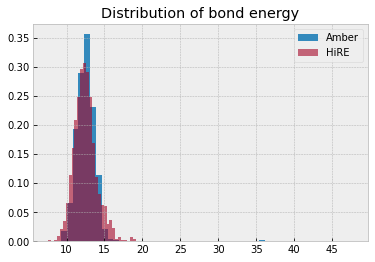

In [15]:
# histogram of amber bond energies

bond_energies = []
bond_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][0,9]   
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[0]
    #if torch.isnan(en2): #or torch.isnan(en2):
    #    continue
    bond_energies.append(en1.item())
    bond_computed_energies.append(en2.item())
print(len(bond_energies))
print(len(bond_computed_energies))

hist1 = plt.hist(bond_energies,bins=50,density=True,label='Amber')
hist2 = plt.hist(bond_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of bond energy')
plt.legend()
plt.show()

1638
1638


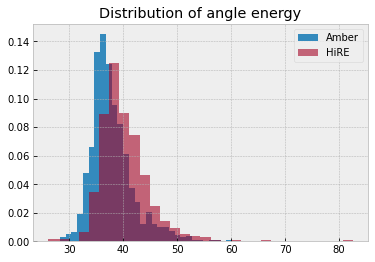

In [16]:
angle_energies = []
angle_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][1,9]   
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[1]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    angle_energies.append(en1.item())
    angle_computed_energies.append(en2.item())
print(len(angle_energies))
print(len(angle_computed_energies))

hist1 = plt.hist(angle_energies,bins=30,density=True,label='Amber')
hist2 = plt.hist(angle_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of angle energy')
plt.legend()
plt.show()

1638
1638


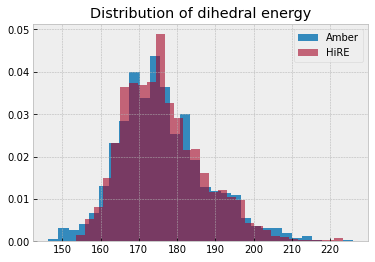

In [17]:
torsion_energies = []
torsion_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][2,9]   
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[2]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    torsion_energies.append(en1.item())
    torsion_computed_energies.append(en2.item())
print(len(torsion_energies))
print(len(torsion_computed_energies))

hist1 = plt.hist(torsion_energies,bins=30,density=True,label='Amber')
hist2 = plt.hist(torsion_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of dihedral energy')
plt.legend()
plt.show()

In [18]:
new_opt_pars = torch.tensor(model.opt_pars)
diff = new_opt_pars - torch.from_numpy(opt_pars)
print(diff)

tensor([-2.3944e+00,  8.0249e-03,  1.3154e-04, -6.4180e-04,  7.3968e-03,
        -1.1023e-01, -6.7355e-02, -1.1225e-01, -3.4255e-02,  1.5388e-01,
        -4.2725e-07,  0.0000e+00, -4.7684e-08,  1.1444e-07, -2.4796e-08,
        -7.8201e-08,  1.5259e-08,  9.5367e-08,  3.8147e-09,  9.9182e-08,
        -3.6240e-08, -9.5367e-09, -7.6294e-09,  0.0000e+00,  0.0000e+00,
        -3.0518e-08, -1.0729e-08,  0.0000e+00,  3.0313e-01, -2.4665e-02,
         1.5287e-02, -2.4023e-01, -2.2092e-01, -2.0574e-01,  7.6759e-02,
         5.1115e-01,  4.1507e-01,  1.9574e-01,  4.7684e-08,  0.0000e+00,
         5.9605e-09, -4.7684e-08,  1.1921e-08, -2.4414e-07,  0.0000e+00,
         0.0000e+00, -1.4537e+00], dtype=torch.float64)


(1638, 3) (1638, 3)


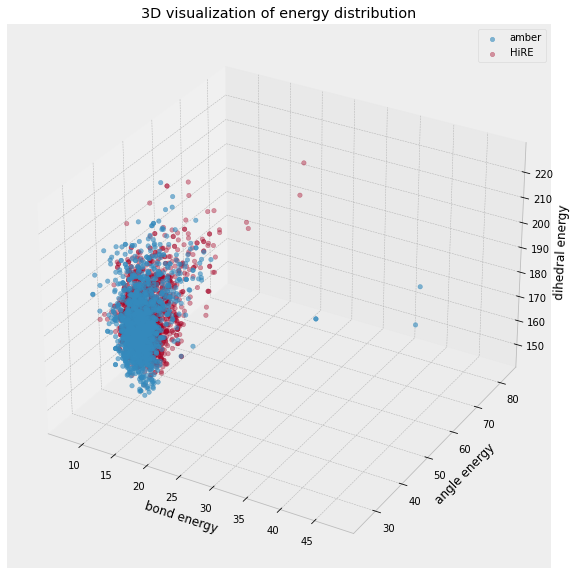

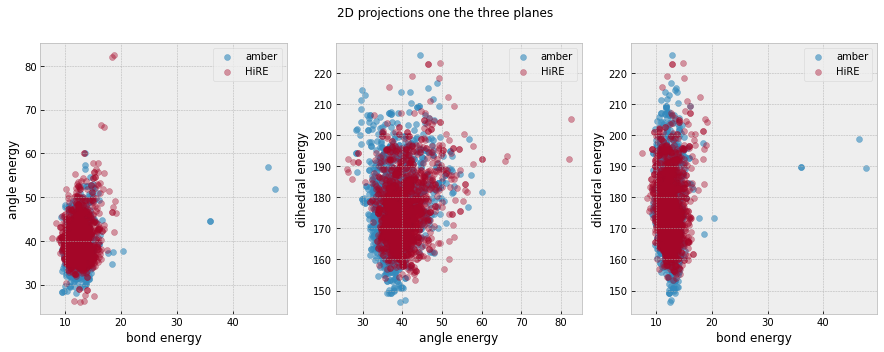

In [23]:
amber = np.array((bond_energies,angle_energies,torsion_energies)).transpose()
HiRE = np.array((bond_computed_energies,angle_computed_energies,torsion_computed_energies)).transpose()
print(amber.shape, HiRE.shape)

# 3D visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(amber[:,0], amber[:,1], amber[:,2], alpha=0.6, label='amber')
ax.scatter(HiRE[:,0], HiRE[:,1], HiRE[:,2], alpha=0.4, label='HiRE')
ax.set_xlabel('bond energy')
ax.set_ylabel('angle energy')
ax.set_zlabel('dihedral energy')
ax.set_title('3D visualization of energy distribution')
ax.legend()
plt.savefig('Images/3Ddist250_0.pdf')
plt.show()

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].scatter(amber[:,0], amber[:,1], alpha=0.6, label='amber')
ax[0].scatter(HiRE[:,0], HiRE[:,1], alpha=0.4, label='HiRE')
ax[0].set_xlabel('bond energy')
ax[0].set_ylabel('angle energy')
ax[0].legend()

ax[1].scatter(amber[:,1], amber[:,2], alpha=0.6, label='amber')
ax[1].scatter(HiRE[:,1], HiRE[:,2], alpha=0.4, label='HiRE')
ax[1].set_xlabel('angle energy')
ax[1].set_ylabel('dihedral energy')
ax[1].legend()

ax[2].scatter(amber[:,0], amber[:,2], alpha=0.6, label='amber')
ax[2].scatter(HiRE[:,0], HiRE[:,2], alpha=0.4, label='HiRE')
ax[2].set_xlabel('bond energy')
ax[2].set_ylabel('dihedral energy')
ax[2].legend()

plt.suptitle('2D projections one the three planes')
plt.show()

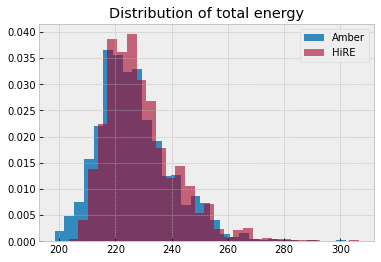

In [20]:
# Overall energy

amber_tot = np.sum(amber, axis=1)
HiRE_tot = np.sum(HiRE, axis=1)

plt.hist(amber_tot,bins=30,density=True,label='Amber')
hist2 = plt.hist(HiRE_tot,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of total energy')
plt.legend()
plt.show()

tensor(50.5095, dtype=torch.float64)
1qd3_c3 tensor(50.5095, dtype=torch.float64)
[ 47.68667984  51.86170578 189.53181458]
[ 12.66711426  38.15014267 187.753479  ]


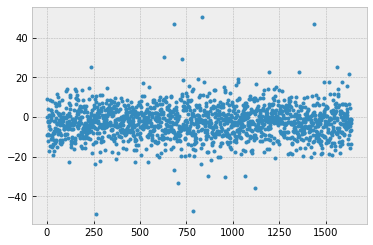

In [21]:
amber_tot = torch.from_numpy(amber_tot)
HiRE_tot = torch.from_numpy(HiRE_tot)

diff = amber_tot - HiRE_tot
nan_idx = torch.isnan(diff).nonzero().squeeze()

file = 'data/SeqCSV/seq_frame.csv'
df = pd.read_csv(file)
names = list(df.iloc[:,0])

plt.plot(diff,'.')

diff[nan_idx] = 0
max_idx = np.argmax(diff)
# print(max_idx)
print(diff[max_idx])
max_diff = max(diff)
print(names[max_idx], max_diff)
print(amber[max_idx])
print(HiRE[max_idx])

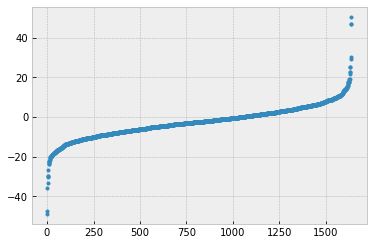

In [22]:
diff = amber_tot - HiRE_tot
nan_idx = torch.isnan(diff).nonzero().squeeze()
diff[nan_idx] = 0

diff, idx = torch.sort(diff)
names[:] = [names[i] for i in idx]

plt.plot(diff,'.')

### Check if sequences in the extremities have common features

dataset allocated on cpu
torch.Size([1638, 10]) torch.Size([1638, 445, 10])


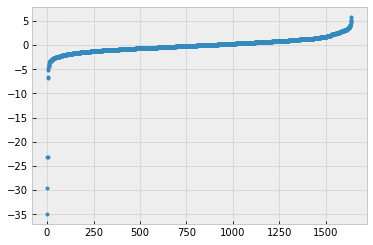

In [30]:
diff_bonds = torch.tensor(bond_computed_energies) - torch.tensor(bond_energies)
diff_bonds, idx = torch.sort(diff_bonds)
plt.plot(diff_bonds,'.')

seq_data = RNASeqDataset(device=device)
print(f'dataset allocated on {device}')
lengths = torch.zeros(len(seq_data),10).long()
features = torch.zeros(len(seq_data),445,10)
for i in range(len(seq_data)):
    lengths[i] = seq_data[i]['lengths']
    features[i] = seq_data[i]['features']
print(lengths.shape, features.shape)
lengths = lengths[idx]
features = features[idx]

[300, 350, 116, 55, 67, 112, 116, 55, 350, 300, 350]


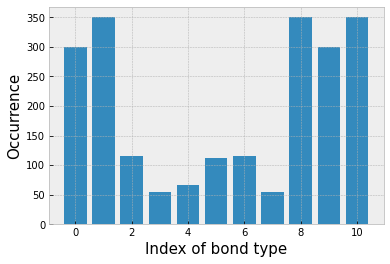

In [31]:
# take only the first 50 elements

diff_bonds_first = diff_bonds[:50]
lengths_first = lengths[:50]
features_first = features[:50]

bt_dict = {classname: 0 for classname in np.arange(0,11)}
btypes = features_first[:,:,6].squeeze().long()
for i in range(len(diff_bonds_first)):
    bt = (btypes[i,:lengths_first[i,6].squeeze()]-1).view(-1,3)[:,2]
    for label in bt:
        bt_dict[label.item()] += 1
print(list(bt_dict.values()))

b_occ = plt.bar(list(bt_dict.keys()),height=list(bt_dict.values()))
plt.xlabel('Index of bond type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/bonds_occurr.pdf')
plt.show()

[300, 350, 97, 102, 65, 86, 97, 102, 350, 300, 350]


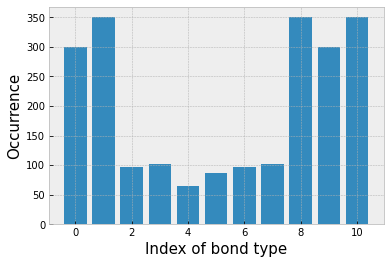

In [33]:
# last 50 elements

diff_bonds_last = diff_bonds[-50:]
lengths_last = lengths[-50:]
features_last = features[-50:]

bt_dict = {classname: 0 for classname in np.arange(0,11)}
btypes = features_last[:,:,6].squeeze().long()
for i in range(len(diff_bonds_last)):
    bt = (btypes[i,:lengths_last[i,6].squeeze()]-1).view(-1,3)[:,2]
    for label in bt:
        bt_dict[label.item()] += 1
print(list(bt_dict.values()))

b_occ = plt.bar(list(bt_dict.keys()),height=list(bt_dict.values()))
plt.xlabel('Index of bond type',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('Images/bonds_occurr.pdf')
plt.show()

In [20]:
from data_classes import LocalEnergyOpt

model = LocalEnergyOpt(fixed_pars,opt_pars,device).to(device)
model.load_state_dict(torch.load("data/Results/try.npy"))

for p in model.parameters():
    print(p)

Parameter containing:
tensor([  2.6891,   2.0812,   1.5192,   2.3615,   4.2127,   4.6113,   4.7343,
          5.6263,   2.1688,   1.1898,  15.2230,   1.0000,   2.8000,   2.5050,
          1.8260,   3.9320,   4.3090,   4.7750,   4.5460,   2.8210,   3.8130,
          3.0100,   0.9080,   3.0000,   4.0000,   2.2570,   0.4800,   0.5000,
          4.5956,  10.7947,  11.0701,   5.5869,   0.3279,   0.5601,   0.3527,
          0.8398,   0.6984,   0.3845,   1.2000,   1.5000,   0.4000,   1.8000,
          0.8000, 142.3060,   1.0000,   0.0000,   0.9308], requires_grad=True)
Parameter containing:
tensor([[ 1.0626,  3.5985],
        [ 1.0090,  2.1805],
        [ 1.0012,  2.5426],
        [ 1.0001,  2.6301],
        [ 1.0000,  3.0677],
        [ 1.0001,  3.0099],
        [ 1.0001,  2.4175],
        [ 1.0000,  2.1771],
        [ 1.0240,  1.1926],
        [ 1.0957,  0.9595],
        [ 1.0110,  1.6501],
        [ 1.0000, 12.0000],
        [ 1.0000, 12.0000],
        [ 1.0000, 12.0000],
        [ 1.0000,

1638
1638


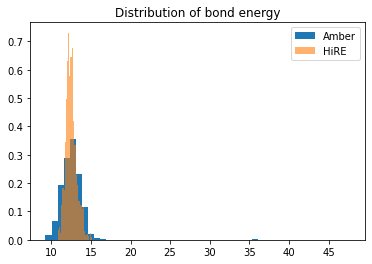

In [21]:
bond_energies = []
bond_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][0,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[0]
    #if torch.isnan(en2): #or torch.isnan(en2):
    #    continue
    bond_energies.append(en1.item())
    bond_computed_energies.append(en2.item())
print(len(bond_energies))
print(len(bond_computed_energies))

hist1 = plt.hist(bond_energies,bins=50,density=True,label='Amber')
hist2 = plt.hist(bond_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of bond energy')
plt.legend()
plt.show()

1638
1638


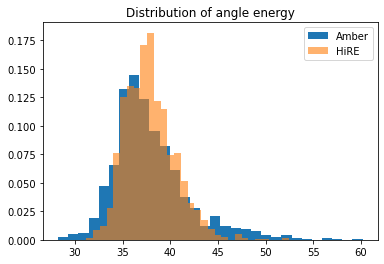

In [22]:
angle_energies = []
angle_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][1,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[1]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    angle_energies.append(en1.item())
    angle_computed_energies.append(en2.item())
print(len(angle_energies))
print(len(angle_computed_energies))

hist1 = plt.hist(angle_energies,bins=30,density=True,label='Amber')
hist2 = plt.hist(angle_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of angle energy')
plt.legend()
plt.show()

1638
1638


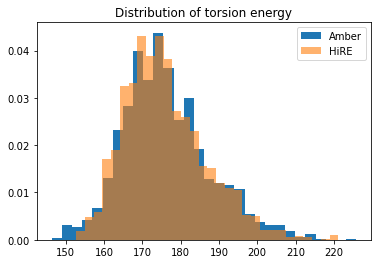

In [23]:
torsion_energies = []
torsion_computed_energies =[]
for i in range(len(seq_data)):
    en1 = seq_data[i]['features'][2,9]
    with torch.no_grad():
        en2 = model(seq_data[i]).squeeze()[2]
    # if torch.isnan(en1) or torch.isnan(en2):
    #    continue
    torsion_energies.append(en1.item())
    torsion_computed_energies.append(en2.item())
print(len(torsion_energies))
print(len(torsion_computed_energies))

hist1 = plt.hist(torsion_energies,bins=30,density=True,label='Amber')
hist2 = plt.hist(torsion_computed_energies,bins=30,density=True,alpha=0.6,label='HiRE')
plt.title('Distribution of torsion energy')
plt.legend()
plt.show()

In [ ]:
lr = 1e-7
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience = 500, cooldown = 1000, threshold = 1e-12, verbose = True)
loss_fn = loss_fn

epochs = 100
train_loss = []
test_loss = []
for index_epoch in range(epochs):
    print(f'epoch {index_epoch+1}/{epochs} \n-------------------------')
    t0 = time.time()
    train_tmp = train(train_dataloader, model, loss_fn, optimizer)
    test_tmp = test(test_dataloader, model, loss_fn)
    tf = time.time()
    print(f'time for epoch: {tf-t0} \n')
    train_loss.append(train_tmp)
    test_loss.append(test_tmp)

print(model.opt_pars)
torch.save(model.state_dict(), 'data/Results/model_pars.pth')

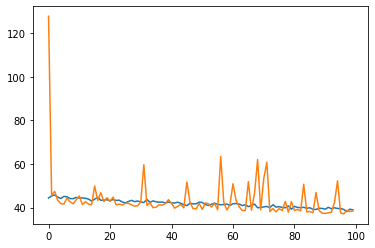

In [23]:
plt.plot(train_loss)
plt.plot(test_loss)